# Challenge Description

We got employee data from a few companies. We have data about all employees who joined
from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the
company as of 2015/12/13 or they have quit. Beside that, we have general info about the
employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers.
Specifically, you should:

* Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. **You should create a table with 3 columns: day, employee_headcount, company_id.**



* What are the main factors that drive employee churn? Do they make sense? Explain your findings.



* If you could add to this data set just one variable that could help explain employee churn, what would that be? 

credit to JifuZhao's repo

### 1. Load data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/employee_retention_data.csv', parse_dates=['join_date', 'quit_date'])
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [2]:
df.shape

(24702, 7)

In [3]:
# check missing value and values
pd.concat([df.apply(lambda x: sum(x.isnull())).rename("num_missing"),
          df.apply(lambda x: len(x.unique())).rename("num_unique")], axis=1)

,num_missing,num_unique
employee_id,0,24702
company_id,0,12
dept,0,6
seniority,0,31
salary,0,367
join_date,0,995
quit_date,11192,665


In [4]:
df.describe(include='all')

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
count,24702.000000,24702.000000,24702,24702.000000,24702.000000,24702,13510
unique,NaN,NaN,6,NaN,NaN,995,664
top,NaN,NaN,customer_service,NaN,NaN,2012-01-03 00:00:00,2015-05-08 00:00:00
freq,NaN,NaN,9180,NaN,NaN,105,111
first,NaN,NaN,NaN,NaN,NaN,2011-01-24 00:00:00,2011-10-13 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2015-12-10 00:00:00,2015-12-09 00:00:00
mean,501604.403530,3.426969,NaN,14.127803,138183.345478,NaN,NaN
std,288909.026101,2.700011,NaN,8.089520,76058.184573,NaN,NaN
min,36.000000,1.000000,NaN,1.000000,17000.000000,NaN,NaN
25%,250133.750000,1.000000,NaN,7.000000,79000.000000,NaN,NaN


### 2. Headcount data manipulation 

In [5]:
date_temp = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
company_temp = sorted(df['company_id'].unique())

In [6]:
date = []
company = []
headcount = []

# cross-join
# headcount = total_join - total_quit
for i in date_temp:
    for j in company_temp:
        date.append(i)
        company.append(j)
        total_join = len(df[(df['join_date'] <= i) & (df['company_id'] == j)])
        total_quit = len(df[(df['quit_date'] <= i) & (df['company_id'] == j)])
        count = total_join - total_quit
        headcount.append(count)
        
df_hc = pd.DataFrame({'date': date,
                     'company_id':company,
                     'headcount': headcount},
                    columns=['date','company_id','headcount'])

In [7]:
df_hc.head()

,date,company_id,headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


In [8]:
df_hc.shape

(21420, 3)

In [9]:
# df_hc.to_csv('../data/employee_headcount.csv')

### 3. Date and period

In [10]:
# Separate stay and quit data
quit_data = df[~df['quit_date'].isnull()]
stay_data = df[df['quit_date'].isnull()]

In [11]:
work_days = np.array(list(map(lambda x: x.days, quit_data['quit_date'] - quit_data['join_date'])))
quit_week = np.array(list(map(lambda x: x.week, quit_data['quit_date'])))
quit_month = np.array(list(map(lambda x: x.month, quit_data['quit_date'])))

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Frequency')

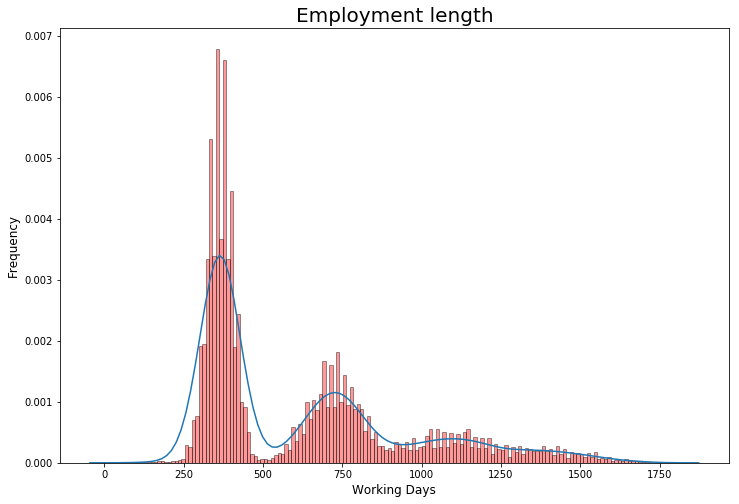

In [12]:
# Total working days
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(work_days,
             bins=150,
             kde=True,
             ax=ax,
             hist_kws={'histtype': 'bar', 'edgecolor':'black', 'color':'red'})
ax.set_title('Employment length', fontsize=20)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Frequency')

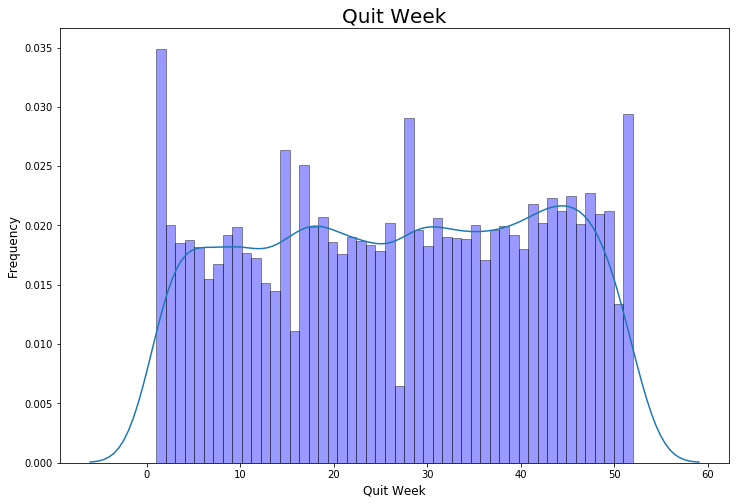

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(quit_week,
             bins=50,
             kde=True,
             ax=ax,
             hist_kws={'histtype': 'bar', 'edgecolor':'black', 'color':'blue'})
ax.set_title('Quit Week', fontsize=20)
ax.set_xlabel('Quit Week', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Frequency')

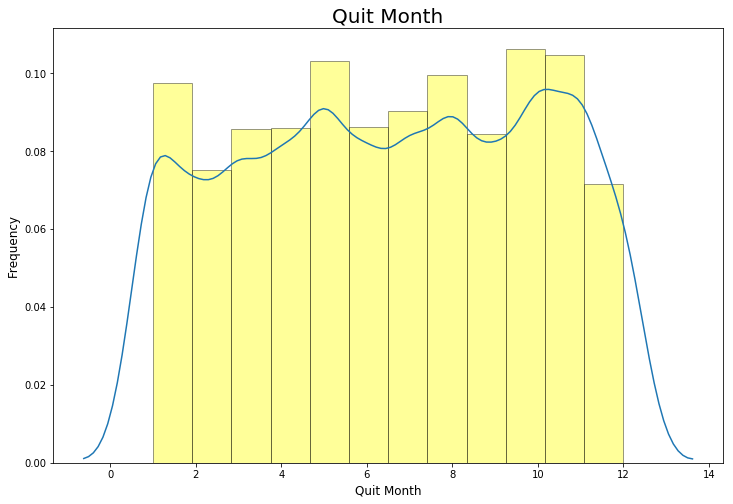

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(quit_month,
             bins=12,
             kde=True,
             ax=ax,
             hist_kws={'histtype': 'bar', 'edgecolor':'black', 'color':'yellow'})
ax.set_title('Quit Month', fontsize=20)
ax.set_xlabel('Quit Month', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

### 4. Churn Analysis 

In [15]:
quit_data['work_days'] = work_days
quit_data['quit_week'] = quit_week

quit_data.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,work_days,quit_week
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,44
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,14
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,23
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,34
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578,35


In [16]:
# Choose the subset data
stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=396)
subset = df[df['join_date'] < stop_date]

# Binary label for early quit (less than 13 months)
quit = subset['quit_date'].isnull() | (subset['quit_date'] > subset['join_date'] + pd.DateOffset(days=396))
subset['quit'] = 1 - quit.astype(int)

subset.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


In [50]:
# get dummies for company and dept

subset['company_id'] = subset['company_id'].astype(str)
X = pd.get_dummies(subset, ['company_id','dept'])
y = X.quit.values
X = X.drop(['quit','join_date','quit_date','employee_id'], axis=1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
X.shape, y.shape

((19270, 20), (19270,))

In [54]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=233)
clf = clf.fit(X, y)

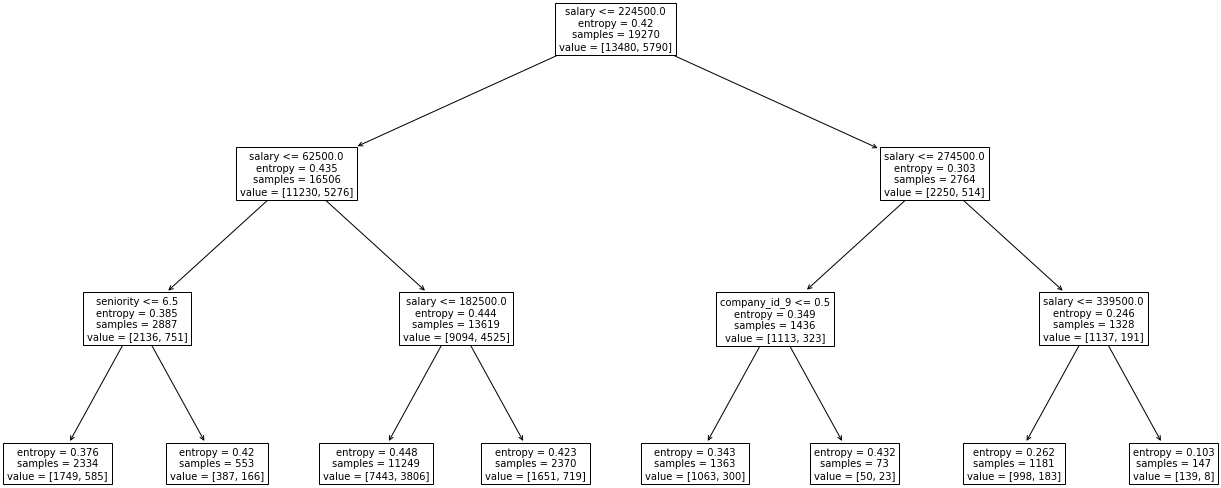

In [55]:
# a package independent from graphviz, credit to andrew muller

from tree_plotting import plot_tree
plt.figure(figsize=(20,8))
tree_dot = plot_tree(clf, feature_names=X.columns.values)

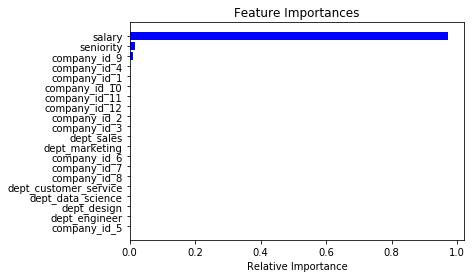

In [56]:
# feature importance


# plot rf feature importance 

features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Other Factors

1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.


2. The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.



3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.